In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [11]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [18]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [20]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

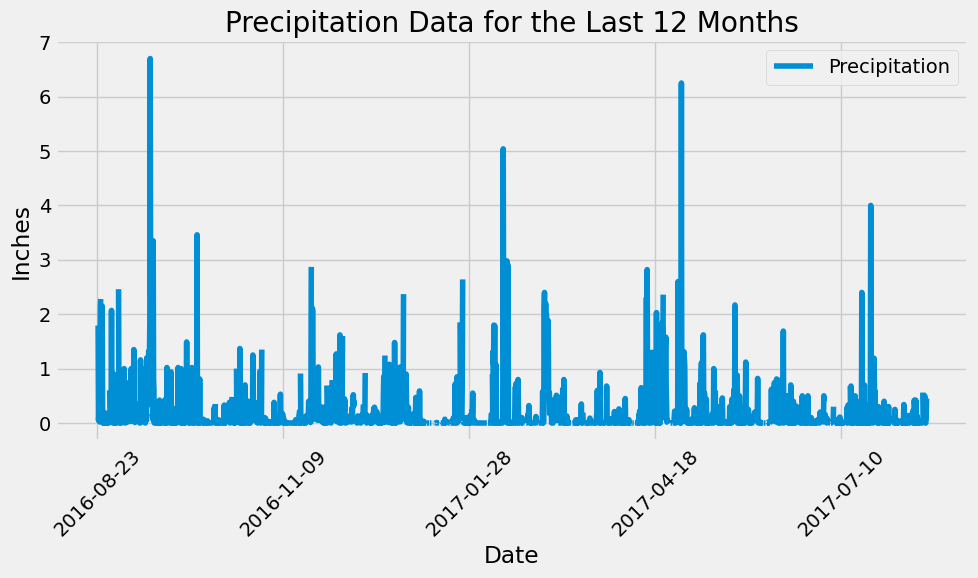

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
query = """
    SELECT date, prcp 
    FROM measurement
    WHERE date >= (SELECT DATE(MAX(date), '-1 year') FROM measurement)
"""

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(query, engine)
df.columns = ['Date', 'Precipitation']
# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats = df["Precipitation"].describe()
print(sum_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [26]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [33]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()
total_stations

9

In [59]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [
    Measurement.station,
    func.count().label('observation_count')
]
most_active_stations = (
    session.query(*sel)
    .group_by(Measurement.station)
    .order_by(func.count().desc())
    .all()
)
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [60]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
]
most_active_temp = session.query(*sel).\
    filter(Measurement.station == "USC00519281")
most_active_temp.one()

(54.0, 85.0, 71.66378066378067)

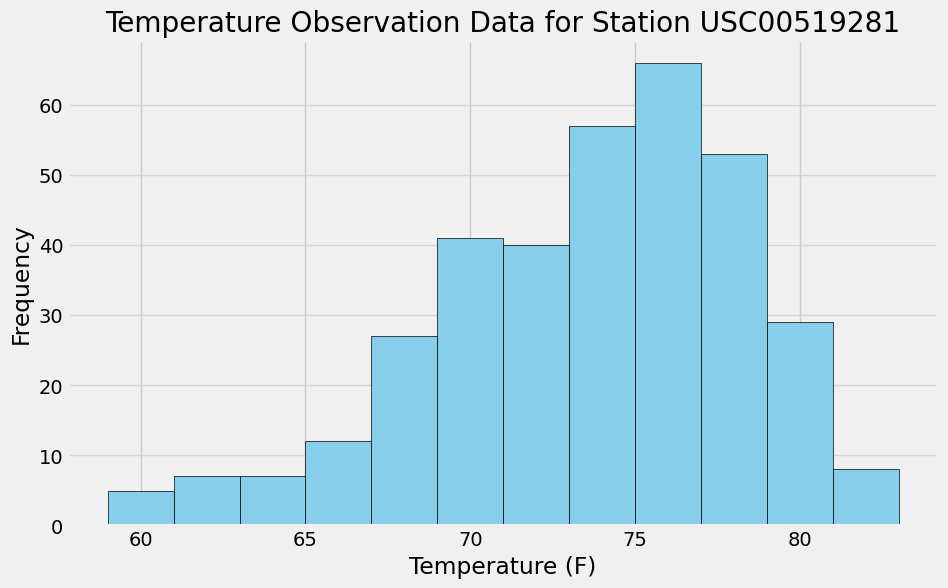

In [61]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = 'USC00519281'
most_active_station_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()

most_active_station_df = pd.DataFrame(most_active_station_data, columns=['Date', 'Temperature'])

plt.figure(figsize=(10,6))
plt.hist(most_active_station_df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Station USC00519281')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Close Session

In [62]:
# Close Session
session.close()